In [1]:
!nvidia-smi

Thu Jun 23 12:19:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:D8:00.0 Off |                  Off |
| 35%   41C    P8     7W / 260W |  16622MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%ls

Datasets/                                 nltk_data/
GermanT5-RP-Mod/                          ray_results/
RP-Mod/                                   results/
RP-Mod-GermanT5-oscar-german-small-el32/  t5_base_imdb_sentiment/
T5FineTuner.py                            t5_german_small_rp_mod/
__pycache__/                              t5_german_small_rp_mod_2/
aclImdb/                                  t5_german_small_rp_mod_3/
aclImdb_v1.tar.gz                         t5_imdb_sentiment/
arguments_test_dir/                       utils-0.py
create_t5_embeddings.ipynb                utils.ipynb
import-notebook-as-module.py              wandb/
lightning_logs/


In [6]:
import fine_tuning_t5_classification

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isado\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [5]:
import utils

ModuleNotFoundError: No module named 'utils'

In [3]:
!nvidia-smi

Thu Jun 23 11:08:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8    19W /  N/A |    219MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from T5FineTuner import T5FineTuner, RPDataset
from utils import get_folds
import torch
import argparse
from transformers import T5Tokenizer
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

DATASET = "RP-Crowd-3"
MODEL_NAME_OR_PATH = "GermanT5/t5-efficient-oscar-german-small-el32"
WANDB_PROJECT_NAME = "rp-crowd-3-folds-cyclic-learning-t5-efficient-small-el32"
OUTPUT_DIR = "./GermanT5-RP-Mod/t5-efficient-oscar-german-small-el32/"
SOURCE = f"./Datasets/{DATASET}-folds.csv"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME_OR_PATH)
train_inputs, train_targets, val_inputs, val_targets = get_folds(SOURCE)

train_dataset = RPDataset(tokenizer, train_inputs, train_targets)
valid_dataset = RPDataset(tokenizer, val_inputs, val_targets)

[nltk_data] Downloading package punkt to /home/dobby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[nltk_data] Downloading package punkt to /home/dobby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import csv

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

# eval packages
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

from torch.optim import AdamW

from transformers import (
    # AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)



class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    # self.hparams.save_hyperparameters(hparams)
    self.save_hyperparameters(hparams)
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
    self.train_dataset = self.hparams.train_dataset
    self.val_dataset = self.hparams.val_dataset
    
  def is_logger(self):
    return self.trainer.global_rank <= 0
  

  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=labels,
        # lm_labels=lm_labels,
    )

  def _step(self, batch):
    labels = batch["target_ids"]
    labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        labels=labels,
        # lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss
  
  def get_accuracy(self, batch):
    labels = batch["target_ids"]

    outs = self.model.generate(input_ids=batch["source_ids"], 
                                attention_mask=batch["source_mask"], 
                                max_length=2)

    dec = [self.tokenizer.decode(ids) for ids in outs]
    target = [self.tokenizer.decode(label) for label in labels]

    new_outputs = [s[6:] for s in dec]
    new_targets = [s[:-4] for s in target]

    accuracy_score = metrics.accuracy_score(new_targets, new_outputs)
    f1 = metrics.f1_score(new_targets, new_outputs, average="micro")
    # rec = metrics.recall_score(new_targets, new_outputs, average="micros")
    return accuracy_score, f1
  # def computer_accuracy(self):
  #   self.model.model.eval()

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)
    self.log("train_loss", loss)
    return {"loss": loss}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    self.log("avg_train_loss", avg_train_loss)
    
  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    accuracy, f1 = torch.tensor(self.get_accuracy(batch))
    self.log("val_loss", loss, logger=True)
    self.log("val_accuracy", accuracy, logger=True)
    return {"val_loss": loss, "val_accuracy": accuracy}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    avg_accuracy = torch.stack([x["val_accuracy"] for x in outputs]).mean()
    # tensorboard_logs = {"val_loss": avg_loss}
    self.log("avg_val_loss", avg_loss)
    self.log("avg_val_accuracy", avg_accuracy)
    # self.log("log", tensorboard_logs)
    # self.log("progress_bar", tensorboard_logs)
    # self.log({"avg_val_loss": avg_loss, 
    #           "log": tensorboard_logs,
    #           'progress_bar': tensorboard_logs}, logger=True, prog_bar=True)
    return {"avg_val_loss": avg_loss, "avg_val_accuracy": avg_accuracy}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    # lr_schedulers = {"scheduler": }
    return [optimizer]
  
  def optimizer_step(self, 
                      epoch,
                      batch_idx,
                      optimizer,
                      optimizer_idx,
                      second_order_closure=None,
                      on_tpu=None,
                      using_native_amp=None,
                      using_lbfgs=None):
    # if self.trainer.use_tpu:
    #   xm.optimizer_step(optimizer)
    # else:
    optimizer.step(closure=second_order_closure)
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    # train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(self.hparams.train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_ratio * t_total, num_training_steps=t_total
    )
    # cyclic learning rate scheduler
    # up = len(self.train_dataset)//(self.hparams.train_batch_size * self.hparams.gradient_accumulation_steps)
    # scheduler = torch.optim.lr_scheduler.CyclicLR(self.opt, base_lr=4e-5, max_lr=4e-3, step_size_up=up, cycle_momentum=False)
    
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    # val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(self.hparams.val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

[nltk_data] Downloading package punkt to /home/dobby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dobby/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding `LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch (rather, they are called on every optimization step).
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/dobby/RP-Mod/t5-efficient-oscar-german-small-el32/.lr_find_2067ec90-9146-4ff9-a749-bf9de27cc522.ckpt


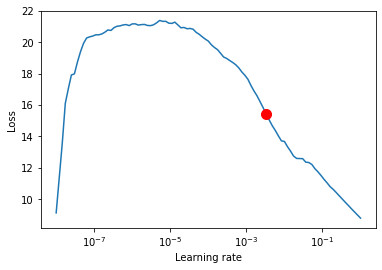

In [18]:
model = T5FineTuner(args)
trainer = pl.Trainer(**train_params)


lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
# print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [3]:
model = T5FineTuner(args)
trainer = pl.Trainer(**train_params)

trainer.fit(model)

NameError: name 'args' is not defined

In [4]:
from pytorch_lightning.callbacks import LearningRateMonitor
wd = 0.1
lr = 4e-4
args_dict = dict(
            data_dir="", # path for data files
            output_dir=f"./GermanT5-RP-Mod/t5-efficient-oscar-german-small-el32/", # path to save the checkpoints
            model_name_or_path="GermanT5/t5-efficient-oscar-german-small-el32",
            tokenizer_name_or_path="GermanT5/t5-efficient-oscar-german-small-el32",
            dataset_name="RP-Mod",
            max_seq_length=512,
            learning_rate=lr,
            weight_decay=wd,
            adam_epsilon=1e-8,
            # warmup_steps=100,
            warmup_ratio=0.3,
            train_batch_size=8,
            eval_batch_size=8,
            num_train_epochs=15,
            gradient_accumulation_steps=16,
            n_gpu=1,
            early_stop_callback=False,
            fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
            opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
            max_grad_norm=0.5, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
            seed=42,
            train_dataset=train_dataset, 
            val_dataset=valid_dataset
        )

args = argparse.Namespace(**args_dict)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=OUTPUT_DIR + f"warm-up-{args.warmup_ratio}-wd-{wd}", filename="{epoch}-{val_accuracy:.2f}-{val_loss:.2f}", monitor="val_accuracy", mode="max", save_top_k=5
        )

wandb.finish()
wandb_logger = WandbLogger(project=WANDB_PROJECT_NAME, 
name=f"cyclic-learning_rate-no-monitor-weight_decay-{wd}")

train_params = dict(
            accumulate_grad_batches=args.gradient_accumulation_steps,
            auto_lr_find=True,
            gpus=args.n_gpu,
            max_epochs=args.num_train_epochs,
            default_root_dir=f"/home/dobby/RP-Mod/t5-efficient-oscar-german-small-el32",
            # early_stop_callback=False,
            precision= 16 if args.fp_16 else 32,
            amp_level=args.opt_level,
            gradient_clip_val=args.max_grad_norm,
            # checkpoint_callback=checkpoint_callback,
            logger=wandb_logger,
            enable_checkpointing=checkpoint_callback,
            callbacks=[
                checkpoint_callback, 
                # LearningRateMonitor(logging_interval="step")
                ],
            # callbacks=[raytuner_callback],
            # callbacks=[LoggingCallback()],
            amp_backend="apex"
        )

model = T5FineTuner(args)
trainer = pl.Trainer(**train_params)

trainer.fit(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dobby/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding `LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch (rather, they are called on every optimization step).
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 142 M 
-----------------------------------------------------
142 M     Trainable params
0         Non-trainable params
142 M     Total params
569.289   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
!nvidia-smi

Thu Jun 23 12:24:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:D8:00.0 Off |                  Off |
| 35%   47C    P2    60W / 260W |  22867MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------